# MedNIST - 2D Classification

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 724 kB 5.3 MB/s 


In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.9.dev2203
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 7b99fe4129b2804dbb58a4055314df4493cb488d
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# Variable para declarar directorio donde guardar resultados y reutilizar descargas. En caso contrario, se usará uno temporal.
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp29i1g25g


In [ ]:
# Descargamos Dataset de MedNIST
resource = "https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Downloading...
From: https://drive.google.com/uc?id=1QsnnkvZyJPcbRoV_ArW8SnE1OTuoVbKE
To: /tmp/tmp63e7pn74/MedNIST.tar.gz
100%|██████████| 61.8M/61.8M [00:00<00:00, 63.9MB/s]


2022-01-21 11:25:46,326 - INFO - Downloaded: /tmp/tmp29i1g25g/MedNIST.tar.gz
2022-01-21 11:25:46,502 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-01-21 11:25:46,505 - INFO - Writing into directory: /tmp/tmp29i1g25g.


In [ ]:
# Para hacerlo reproducible
set_determinism(seed=0)

In [ ]:
# Extraemos información del dataset
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


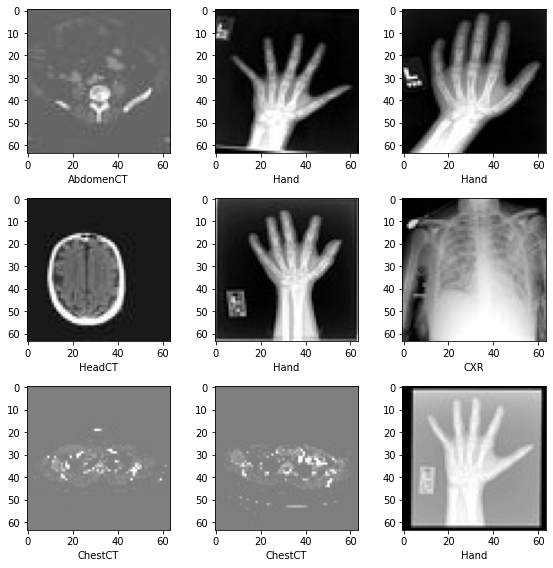

In [ ]:
# Mostramos algunos ejemplos aleatorios del dataset
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
# Preparación de los datos
val_frac = 0.1 # 10% aleatorio para validación
test_frac = 0.1 # 10% aleatorio para test
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


In [ ]:
# Data augmentation
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

In [ ]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

# Conjunto de train
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
print(len(train_ds))
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=2)
# Conjunto de validación
val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=300, num_workers=2)
# Conjunto de test
test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=300, num_workers=2)

47164


In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            # Inicial
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #block 1
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block 7
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #block8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=2048, out_features=128 ),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=128, out_features=num_class)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0], -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# Creating our Neural Network - ResNet18
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # resnet connection at forward

        # Initial convolution before resnet blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        ########## 32x32@64
        # RESNET BLOCK 1
        self.b1_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b1_bn1 = nn.BatchNorm2d(64)
        self.b1_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b1_bn2 = nn.BatchNorm2d(64)
        # RESNET BLOCK 2
        self.b2_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b2_bn1 = nn.BatchNorm2d(64)
        self.b2_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.b2_bn2 = nn.BatchNorm2d(64)

        ########## 16x16@128
        # RESNET BLOCK 3
        # we need to readapt the input map using 1x1 convolution kernel (like a MLP combining channel dimensions)
        self.b3_shortcut = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        )
        self.b3_conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.b3_bn1 = nn.BatchNorm2d(128)
        self.b3_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.b3_bn2 = nn.BatchNorm2d(128)
        # RESNET BLOCK 4
        self.b4_conv1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.b4_bn1 = nn.BatchNorm2d(128)
        self.b4_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.b4_bn2 = nn.BatchNorm2d(128)

        ########## 8x8@256
        # RESNET BLOCK 5
        # we need to readapt the input map using 1x1 convolution kernel (like a MLP combining channel dimensions)
        self.b5_shortcut = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(256)
        )
        self.b5_conv1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.b5_bn1 = nn.BatchNorm2d(256)
        self.b5_conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.b5_bn2 = nn.BatchNorm2d(256)
        # RESNET BLOCK 6
        self.b6_conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.b6_bn1 = nn.BatchNorm2d(256)
        self.b6_conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.b6_bn2 = nn.BatchNorm2d(256)

        ########## 4x4@512
        # RESNET BLOCK 7
        # we need to readapt the input map using 1x1 convolution kernel (like a MLP combining channel dimensions)
        self.b7_shortcut = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512)
        )
        self.b7_conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.b7_bn1 = nn.BatchNorm2d(512)
        self.b7_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.b7_bn2 = nn.BatchNorm2d(512)
        # RESNET BLOCK 8
        self.b8_conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.b8_bn1 = nn.BatchNorm2d(512)
        self.b8_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.b8_bn2 = nn.BatchNorm2d(512)

        ########## 1x1@512
        # Final pooling
        self.average_pooling = nn.AvgPool2d(4)

        ########## 512@num_classes
        # To connect to the number of classes
        self.Linear = nn.Linear(512, num_classes)

    def forward(self, x):
        #### 32x32@3 -> 32x32@64
        # 0. Initial convolution ==> 
        x = F.relu(self.bn1(self.conv1(x)))

        #### 32x32@64 -> 32x32@64
        # 1. First ResNet block
        b1_1 = F.relu(self.b1_bn1(self.b1_conv1(x)))
        b1_2 = self.b1_bn2(self.b1_conv2(b1_1))
        out1 = F.relu(x + b1_2)  # resnet connection plus activation
        # 2. Second ResNet block
        b2_1 = F.relu(self.b2_bn1(self.b2_conv1(out1)))
        b2_2 = self.b2_bn2(self.b2_conv2(b2_1))
        out2 = F.relu(out1 + b2_2)  # resnet connection plus activation

        #### 32x32@64 -> 16x16@128
        # 3. Third ResNet block
        # we need to readapt the number of maps of the input so it matches the output
        shortcut = self.b3_shortcut(out2)
        b3_1 = F.relu(self.b3_bn1(self.b3_conv1(out2)))
        b3_2 = self.b3_bn2(self.b3_conv2(b3_1))
        out3 = F.relu(shortcut + b3_2)  # resnet connection plus activation
        # 4. Fourth ResNet block
        b4_1 = F.relu(self.b4_bn1(self.b4_conv1(out3)))
        b4_2 = self.b4_bn2(self.b4_conv2(b4_1))
        out4 = F.relu(out3 + b4_2)  # resnet connection plus activation

        #### 16x16@128 -> 8x8@256
        # 5. Fifth ResNet block
        # we need to readapt the number of maps of the input so it matches the output
        shortcut = self.b5_shortcut(out4)
        b5_1 = F.relu(self.b5_bn1(self.b5_conv1(out4)))
        b5_2 = self.b5_bn2(self.b5_conv2(b5_1))
        out5 = F.relu(shortcut + b5_2)  # resnet connection plus activation
        # 6. Sixth ResNet block
        b6_1 = F.relu(self.b6_bn1(self.b6_conv1(out5)))
        b6_2 = self.b6_bn2(self.b6_conv2(b6_1))
        out6 = F.relu(out5 + b6_2)  # resnet connection plus activation

        #### 8x8@256 -> 4x4@512
        # 7. Seventh ResNet block
        # we need to readapt the number of maps of the input so it matches the output
        shortcut = self.b7_shortcut(out6)
        b7_1 = F.relu(self.b7_bn1(self.b7_conv1(out6)))
        b7_2 = self.b7_bn2(self.b7_conv2(b7_1))
        out7 = F.relu(shortcut + b7_2)  # resnet connection plus activation
        # 8. Eigth ResNet block
        b8_1 = F.relu(self.b8_bn1(self.b8_conv1(out7)))
        b8_2 = self.b8_bn2(self.b8_conv2(b8_1))
        out8 = F.relu(out7 + b8_2)  # resnet connection plus activation

        #### 4x4@512 -> 1x1@512
        pool_out = self.average_pooling(out8)

        #### 512 -> num_classes
        fc_out = self.Linear(pool_out.view(pool_out.size(0), -1))

        return fc_out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# red
# model = DenseNet121(spatial_dims=2, in_channels=1,
#                     out_channels=num_class).to(device)
model = VGG16().to(device)
loss_function = torch.nn.CrossEntropyLoss()
# optimizador
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #     f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
epoch 1 average loss: 0.6871
saved new best metric model
current epoch: 1 current AUC: 0.9999 current accuracy: 0.9941 best AUC: 0.9999 at epoch: 1
----------
epoch 2/4


KeyboardInterrupt: ignored

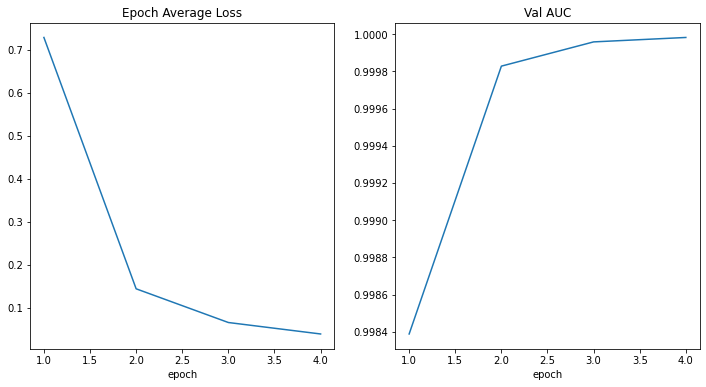

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
# Limpiar directorio
if directory is None:
    shutil.rmtree(root_dir)

# 2D Segmentation

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
)
from monai.visualize import plot_2d_or_3d_image

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

MONAI version: 0.9.dev2203
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 7b99fe4129b2804dbb58a4055314df4493cb488d
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# Variable para declarar directorio donde guardar resultados y reutilizar descargas. En caso contrario, se usará uno temporal.
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmppohqat1t


In [ ]:
for i in range(40):
    im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
    Image.fromarray((im * 255).astype("uint8")).save(os.path.join(root_dir, f"img{i:d}.png"))
    Image.fromarray((seg * 255).astype("uint8")).save(os.path.join(root_dir, f"seg{i:d}.png"))

images = sorted(glob(os.path.join(root_dir, "img*.png")))
segs = sorted(glob(os.path.join(root_dir, "seg*.png")))
print(f"generating synthetic data to {root_dir} (this may take a while)")

generating synthetic data to /tmp/tmppohqat1t (this may take a while)


In [ ]:
# define transforms for image and segmentation
train_imtrans = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandSpatialCrop((96, 96), random_size=False),
    RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    EnsureType(),
])
train_segtrans = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandSpatialCrop((96, 96), random_size=False),
    RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    EnsureType(),
])
val_imtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])
val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()])

In [ ]:
# define array dataset, data loader
check_ds = ArrayDataset(images, train_imtrans, segs, train_segtrans)
check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
im, seg = monai.utils.misc.first(check_loader)
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96]) torch.Size([10, 1, 96, 96])


In [ ]:
# create a training data loader
train_ds = ArrayDataset(images[:20], train_imtrans, segs[:20], train_segtrans)
print(len(train_ds))
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
# create a validation data loader
val_ds = ArrayDataset(images[-20:], val_imtrans, segs[-20:], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

20


In [ ]:
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VGG16().to(device)
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64), # nº canales
    strides=(2, 2), # length channels-1
    #num_res_units=2, # nº unidades residuales
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [ ]:
print(model)

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Convolution(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_ru

In [ ]:
    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(10):
        print("-" * 10)
        #print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)
                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                    #print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

----------
epoch 1 average loss: 0.4711
----------
epoch 2 average loss: 0.3820
current epoch: 2 current mean dice: 0.7269 best mean dice: 0.7269 at epoch 2
----------
epoch 3 average loss: 0.3232
----------
epoch 4 average loss: 0.2857
current epoch: 4 current mean dice: 0.8502 best mean dice: 0.8502 at epoch 4
----------
epoch 5 average loss: 0.2456
----------
epoch 6 average loss: 0.2110
current epoch: 6 current mean dice: 0.9737 best mean dice: 0.9737 at epoch 6
----------
epoch 7 average loss: 0.1822
----------
epoch 8 average loss: 0.1601
current epoch: 8 current mean dice: 0.9819 best mean dice: 0.9819 at epoch 8
----------
epoch 9 average loss: 0.1398
----------
epoch 10 average loss: 0.1265
current epoch: 10 current mean dice: 0.9861 best mean dice: 0.9861 at epoch 10
train completed, best_metric: 0.9861 at epoch: 10


In [ ]:
# Limpiar directorio
if directory is None:
    shutil.rmtree(root_dir)

# 3D Segmentation

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 728 kB 5.4 MB/s 
     |████████████████████████████████| 251 kB 50.8 MB/s 


In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [ ]:
# Para hacerlo reproducible
set_determinism(seed=0)

In [ ]:
# Descargamos los datos
root_dir = tempfile.mkdtemp()
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [01:16, 21.0MB/s]                            

2022-01-24 09:16:40,743 - INFO - Downloaded: /tmp/tmpkz48lh4r/Task09_Spleen.tar


2022-01-24 09:16:44,015 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-01-24 09:16:44,017 - INFO - Writing into directory: /tmp/tmpkz48lh4r.


In [ ]:
# Buscamos los datos descargados y separamos para crear los conjuntos de train y test
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, test_files = data_dicts[:-9], data_dicts[-9:]

In [ ]:
# Misma estructura que PyTorch en las prácticas.
# Constants definition. 
batch_size = 2
epochs = 600
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_transforms = Compose([
  LoadImaged(keys=["image", "label"]),
  EnsureChannelFirstd(keys=["image", "label"]),
  Spacingd(keys=["image", "label"], pixdim=(
      1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  ScaleIntensityRanged(
      keys=["image"], a_min=-57, a_max=164,
      b_min=0.0, b_max=1.0, clip=True,
  ),
  CropForegroundd(keys=["image", "label"], source_key="image"),
  RandCropByPosNegLabeld(
      keys=["image", "label"],
      label_key="label",
      spatial_size=(96, 96, 96),
      pos=1,
      neg=1,
      num_samples=4,
      image_key="image",
      image_threshold=0,
  ),
  EnsureTyped(keys=["image", "label"]),
])

train_dataset = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_transforms = Compose([
  LoadImaged(keys=["image", "label"]),
  EnsureChannelFirstd(keys=["image", "label"]),
  Spacingd(keys=["image", "label"], pixdim=(
      1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
  Orientationd(keys=["image", "label"], axcodes="RAS"),
  ScaleIntensityRanged(
      keys=["image"], a_min=-57, a_max=164,
      b_min=0.0, b_max=1.0, clip=True,
  ),
  CropForegroundd(keys=["image", "label"], source_key="image"),
  EnsureTyped(keys=["image", "label"]),
])

test_dataset = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2)

In [ ]:
# Statistics printing
for data in train_loader:
  x_batch = data['image']
  y_batch = data['label']
  break
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))

for data in test_loader:
  x_batch = data['image']
  y_batch = data['label']
  break
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))
# Al ser segmentación 3D, cno es necesario tener una gran cantidad de muestras (al menos en esta categoría de aplicaciones)

Training set: 32 samples - Max value: 1.0 - Min value: 0.0
Test set: 9 samples - Max value: 1.0 - Min value: 0.0
Example batch shape: torch.Size([1, 1, 226, 157, 113])


image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


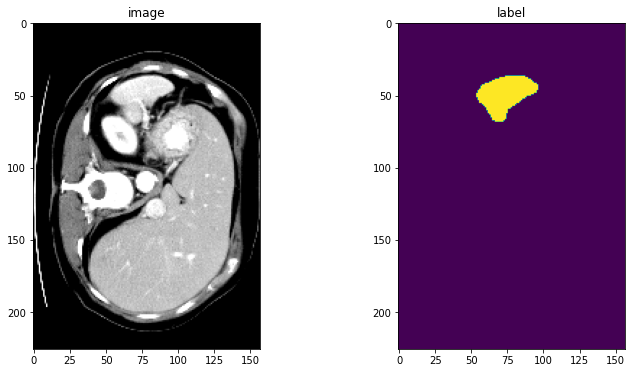

In [ ]:
# OPCIONAL --> Echamos un vistazo a una imagen y cómo es su segmentación 
check_dataset = Dataset(data=test_files, transform=test_transforms)
check_loader = DataLoader(check_dataset, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [ ]:
# Instantiating the network and printing its architecture
net = UNet(
    spatial_dims=3, # segmentación de 3 dimensiones
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2), # Longitud channels -1 
    num_res_units=2, # nº de unidades residuales
    norm=Norm.BATCH,
).to(device)
print(net)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [ ]:
# Training hyperparameters
criterion = DiceLoss(to_onehot_y=True, softmax=True) # Criterio para segmentación
optimizer = torch.optim.Adam(net.parameters(), 1e-4)
#optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 50
# lr = 0.01    if 50 <= epoch < 100
# lr = 0.001   if epoch >= 100
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5) # factor 0.1 de serie. Lo usaremos sobre dice ('accuracy') por lo que maximizaremos

In [ ]:
best_metric = -1
train_loss_values = []
metric_values = []
# Para cálculo de Dice
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
print("\n---- Start Training ----")
for epoch in range(epochs):
  # TRAIN THE NETWORK
    net.train()
    train_loss = 0
    for batch_data in train_loader:
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # Cálculo del loss, como hasta ahora
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)/2
    train_loss_values.append(train_loss)
   # TEST NETWORK
    net.eval()
    with torch.no_grad():
      for test_data in test_loader:
            inputs, labels = (
                test_data["image"].to(device),
                test_data["label"].to(device),
            )
            roi_size = (160, 160, 160) # regions of interest
            metric_outputs = sliding_window_inference(
                inputs, roi_size, 4, net)
            metric_outputs = [post_pred(i) for i in decollate_batch(metric_outputs)]
            metric_labels = [post_label(i) for i in decollate_batch(labels)]
            # En lugar de loss, calculamos la métrica (mean dice) por lo que se han transformado outputs y targets para obtenerlo
            dice_metric(y_pred=metric_outputs, y=metric_labels)
      metric = 100. * dice_metric.aggregate().item()
      # reset the status for next validation round
      dice_metric.reset()

      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        torch.save(net.state_dict(), os.path.join(
            root_dir, "best_metric_model.pth"))
       # Get current learning rate via the optimizer
      for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
      print(f"[Epoch {epoch + 1}] with LR: {current_lr:.5f} - Average train loss: {train_loss:.4f} - Test mean dice: {metric:.2f}%")
      #scheduler.step() # en caso de usar scheduler por escalones fijos
      #scheduler.step(metric) # si usamos plateau como lr scheduler
print('Finished Training')
print("Best Test accuracy: {:.2f}".format(best_metric))


---- Start Training ----
[Epoch 1] with LR: 0.00010 - Average train loss: 0.6616 - Test mean dice: 1.51%
[Epoch 2] with LR: 0.00010 - Average train loss: 0.6403 - Test mean dice: 2.64%
[Epoch 3] with LR: 0.00010 - Average train loss: 0.6201 - Test mean dice: 4.32%
[Epoch 4] with LR: 0.00010 - Average train loss: 0.6018 - Test mean dice: 5.78%
[Epoch 5] with LR: 0.00010 - Average train loss: 0.5891 - Test mean dice: 7.25%
[Epoch 6] with LR: 0.00010 - Average train loss: 0.5900 - Test mean dice: 8.86%
[Epoch 7] with LR: 0.00010 - Average train loss: 0.5787 - Test mean dice: 7.77%
[Epoch 8] with LR: 0.00010 - Average train loss: 0.5734 - Test mean dice: 10.73%
[Epoch 9] with LR: 0.00010 - Average train loss: 0.5721 - Test mean dice: 10.20%
[Epoch 10] with LR: 0.00010 - Average train loss: 0.5527 - Test mean dice: 10.19%
[Epoch 11] with LR: 0.00010 - Average train loss: 0.5391 - Test mean dice: 14.17%
[Epoch 12] with LR: 0.00010 - Average train loss: 0.5327 - Test mean dice: 11.60%
[Epoch

NameError: ignored

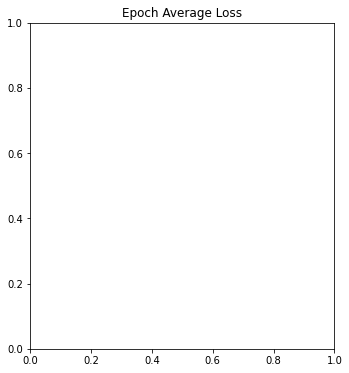

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(epoch_loss_values)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(metric_values)
plt.show()

In [ ]:
net.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)